<a href="https://colab.research.google.com/github/DLShrankhala/DevelopingVariousLSTMModelForTimeSeriesForecasting-ai-25/blob/main/Nakul_MSFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle

In [2]:
class Data:
    def __init__(self):
        self.dataframe = pd.DataFrame([])

    def read(self, file_name: str):
        """Reads a CSV file into the dataframe."""
        if os.path.exists(file_name):
            self.dataframe = pd.read_csv(file_name)
            print(f"Data successfully read from {file_name}.")
        else:
            print(f"Error: The file {file_name} does not exist.")

    def clean_data(self):
        """Removes null values from the dataframe."""
        initial_shape = self.dataframe.shape
        self.dataframe.dropna(inplace=True)
        final_shape = self.dataframe.shape
        print(f"Data cleaned: {initial_shape[0] - final_shape[0]} rows removed.")

    def print_head(self):
        """Prints first few rows of the dataframe."""
        print(self.dataframe.head())

    def print_description(self):
        """Prints the description of the dataframe."""
        print(self.dataframe.describe())

    def normalize(self):
        """Normalizes numeric columns in the dataframe."""
        numeric_cols = self.dataframe.select_dtypes(include=['float64', 'int64']).columns
        self.scaler = MinMaxScaler()
        self.dataframe[numeric_cols] = self.scaler.fit_transform(self.dataframe[numeric_cols])
        print(f"Data normalized for columns: {numeric_cols.tolist()}")

    def visualize_open(self):
        """Plot graph for open stock values v/s date"""
        if 'Date' in self.dataframe.columns and 'Open' in self.dataframe.columns:
            self.dataframe['Date'] = pd.to_datetime(self.dataframe['Date'])
            plt.figure(figsize=(14, 7))
            plt.plot(self.dataframe['Date'], self.dataframe['Open'], label='Open Stock Prices')
            plt.title('Open Stock Prices Over Time')
            plt.xlabel('Date')
            plt.ylabel('Open Stock Price')
            plt.legend()
            plt.show()
        else:
            print("Date and/or Open column not found in the dataframe")

    def visualize_close(self):
        """Plot graph for close stock values v/s date"""
        if 'Date' in self.dataframe.columns and 'Close' in self.dataframe.columns:
            self.dataframe['Date'] = pd.to_datetime(self.dataframe['Date'])
            plt.figure(figsize=(14, 7))
            plt.plot(self.dataframe['Date'], self.dataframe['Close'], label='Close Stock Prices')
            plt.title('Close Stock Prices Over Time')
            plt.xlabel('Date')
            plt.ylabel('Close Stock Price')
            plt.legend()
            plt.show()
        else:
            print("Date and/or Close column not found in the dataframe")



In [3]:

data = Data()


In [4]:

data.read('/content/MSFT.csv')

Data successfully read from /content/MSFT.csv.


In [5]:
data.clean_data()

Data cleaned: 0 rows removed.


In [6]:
data.print_head()

         Date        Open        High         Low       Close   Adj Close  \
0  2019-06-12  131.399994  131.970001  130.710007  131.490005  125.401436   
1  2019-06-13  131.979996  133.000000  131.559998  132.320007  126.193008   
2  2019-06-14  132.259995  133.789993  131.639999  132.449997  126.316978   
3  2019-06-17  132.630005  133.729996  132.529999  132.850006  126.698471   
4  2019-06-18  134.190002  135.240005  133.570007  135.160004  128.901520   

     Volume  
0  17092500  
1  17200800  
2  17821700  
3  14517800  
4  25934500  


In [7]:

data.print_description()

              Open         High          Low        Close    Adj Close  \
count  1259.000000  1259.000000  1259.000000  1259.000000  1259.000000   
mean    262.223495   264.850318   259.495131   262.305655   257.420765   
std      77.387412    77.803210    76.846402    77.388209    78.831097   
min     131.399994   131.970001   130.710007   131.490005   125.401436   
25%     210.479996   212.465004   208.095001   210.355004   203.574219   
50%     257.510010   260.119995   254.470001   257.220001   252.241074   
75%     314.509994   318.025009   311.519989   314.975006   311.409714   
max     432.970001   433.600006   427.160004   432.679993   432.679993   

             Volume  
count  1.259000e+03  
mean   2.894407e+07  
std    1.252017e+07  
min    8.989200e+06  
25%    2.103170e+07  
50%    2.577390e+07  
75%    3.315345e+07  
max    9.701270e+07  


In [8]:

data.normalize()

Data normalized for columns: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


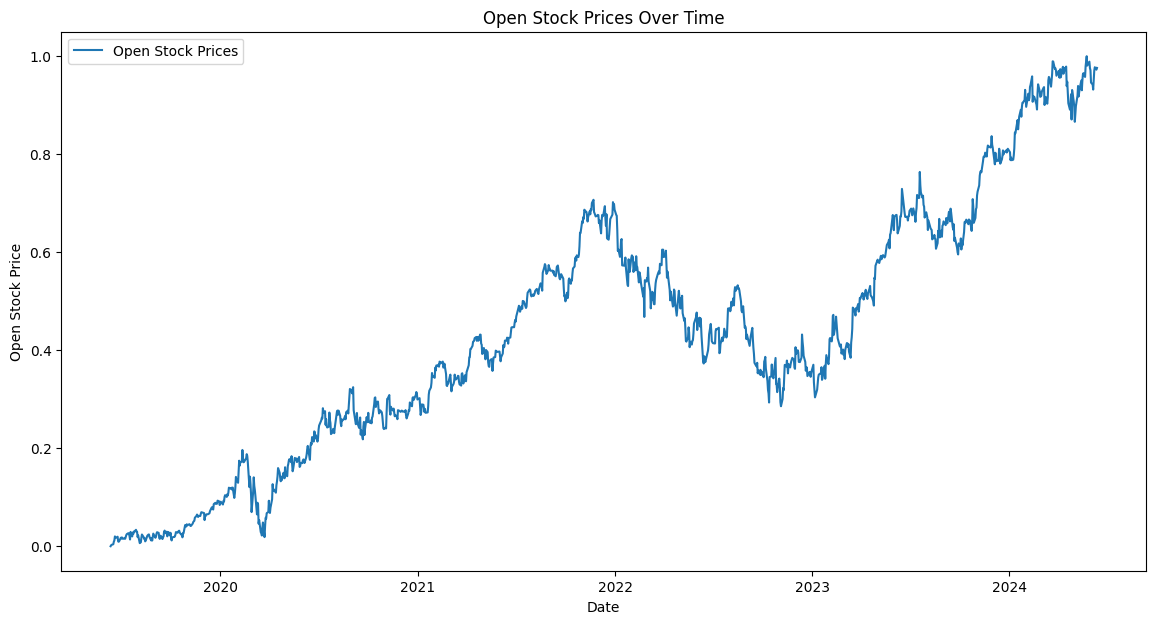

In [9]:
data.visualize_open()

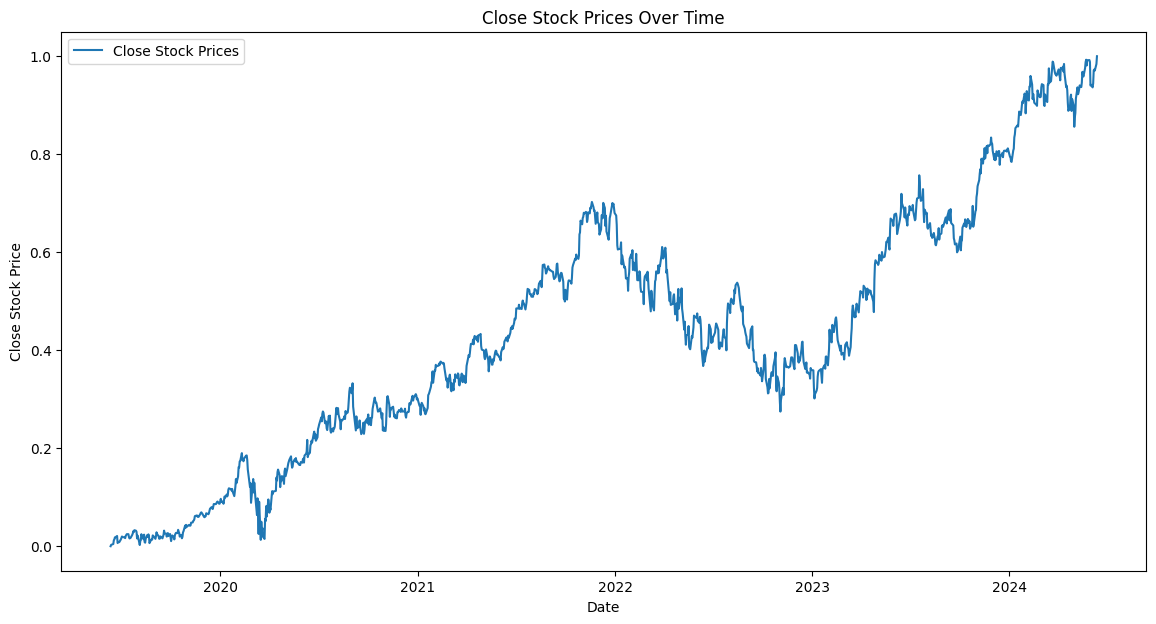

In [10]:
data.visualize_close()

In [11]:
class LSTMTrainer:
    def __init__(self, dataframe, scaler):
        self.dataframe = dataframe
        self.scaler = scaler

    def prepare_data_for_lstm(self, feature_col='Close', look_back=60):
        """Prepare data for LSTM by creating sequences"""
        data = self.dataframe[feature_col].values
        data = data.reshape(-1, 1)  # Reshape to (n_samples, 1)
        X, y = [], []
        for i in range(len(data) - look_back):
            X.append(data[i:i + look_back])
            y.append(data[i + look_back])
        X, y = np.array(X), np.array(y)

        # Split data while preserving the number of features
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
        return X_train, X_test, y_train, y_test.reshape(-1, 1)

    def build_and_train_lstm(self, feature_col='Close', look_back=60, epochs=40, batch_size=32):
        """Build and train the LSTM model"""
        X_train, X_test, y_train, y_test = self.prepare_data_for_lstm(feature_col, look_back)

        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
        model.add(LSTM(units=50))
        model.add(Dense(1))

        model.compile(optimizer='adam', loss='mean_squared_error')
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

        self.model = model
        self.X_test = X_test
        self.y_test = y_test

    def predict_and_plot(self):
        """Make predictions and plot the results"""
        predictions = self.model.predict(self.X_test)
        predictions = predictions.reshape(-1, 1)

        # Extract the 'Close' column from the original dataframe
        self.close_scaler = MinMaxScaler(feature_range=(0, 1))  # Create a new scaler for just the 'Close' column
        self.close_scaler.fit(self.dataframe['Close'].values.reshape(-1, 1))  # Fit the scaler to the 'Close' column

        # Inverse transform predictions using the scaler fitted on 'Close' column
        predictions = self.close_scaler.inverse_transform(predictions)
        # Inverse transform actual 'Close' values
        actual = self.close_scaler.inverse_transform(self.y_test)

        plt.figure(figsize=(14, 7))
        plt.plot(actual, label='Actual Stock Price')
        plt.plot(predictions, label='Predicted Stock Price')
        plt.title('Actual vs Predicted Stock Prices')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()

    def evaluate_model(self):
        """Calculates and prints evaluation metrics."""
        predictions = self.model.predict(self.X_test)
        predictions = self.close_scaler.inverse_transform(predictions)  # Assuming you're using the close_scaler
        actual = self.close_scaler.inverse_transform(self.y_test)

        mse = mean_squared_error(actual, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(actual, predictions)
        r2 = r2_score(actual, predictions)

        print(f"Mean Squared Error (MSE): {mse}")
        print(f"Root Mean Squared Error (RMSE): {rmse}")
        print(f"Mean Absolute Error (MAE): {mae}")
        print(f"R-squared (R2): {r2}")



In [12]:

trainer = LSTMTrainer(data.dataframe, data.scaler)

In [13]:
trainer.build_and_train_lstm(feature_col='Close', look_back=60, epochs=5, batch_size=1)

Epoch 1/5
959/959 [==============================] - 40s 33ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 2/5
959/959 [==============================] - 26s 27ms/step - loss: 7.9260e-04 - val_loss: 0.0010
Epoch 3/5
959/959 [==============================] - 29s 30ms/step - loss: 7.6433e-04 - val_loss: 3.2419e-04
Epoch 4/5
959/959 [==============================] - 28s 29ms/step - loss: 5.3455e-04 - val_loss: 3.9929e-04
Epoch 5/5
959/959 [==============================] - 26s 27ms/step - loss: 4.7240e-04 - val_loss: 5.6464e-04


8/8 [==============================] - 1s 14ms/step


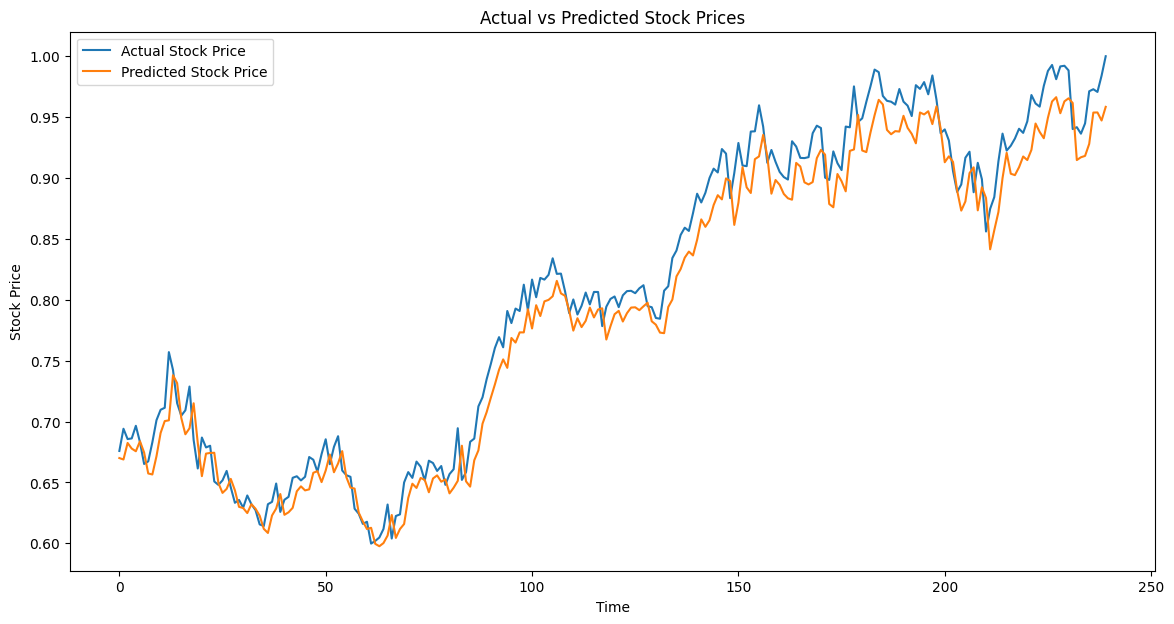

In [14]:
trainer.predict_and_plot()

In [15]:
trainer.evaluate_model()

8/8 [==============================] - 0s 13ms/step
Mean Squared Error (MSE): 0.0005646410553870524
Root Mean Squared Error (RMSE): 0.02376217699174578
Mean Absolute Error (MAE): 0.020037526282224164
R-squared (R2): 0.964551066117981


In [16]:
with open('model.pkl','wb') as f:
  pickle.dump(trainer,f)


In [17]:


with open('model.pkl','rb') as f:
  trained_model = pickle.load(f)

8/8 [==============================] - 1s 13ms/step


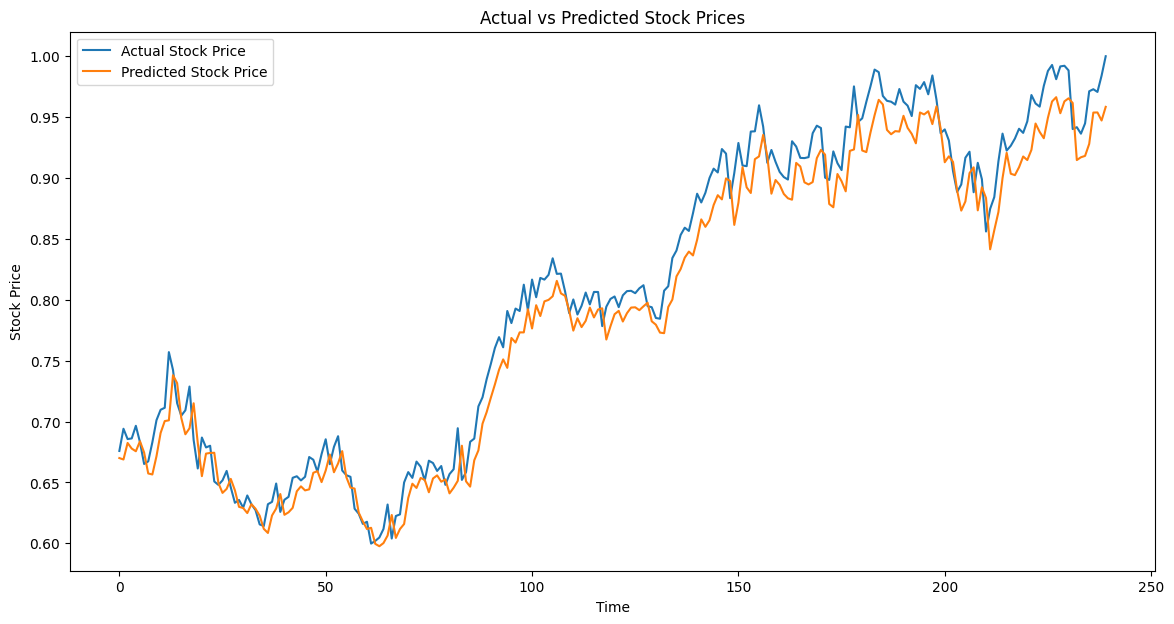

In [18]:

# Predicting and ploting using loaded model
trained_model.predict_and_plot()


In [19]:

trained_model.evaluate_model()

8/8 [==============================] - 0s 14ms/step
Mean Squared Error (MSE): 0.0005646410553870524
Root Mean Squared Error (RMSE): 0.02376217699174578
Mean Absolute Error (MAE): 0.020037526282224164
R-squared (R2): 0.964551066117981


In [22]:
import pickle

# Serialize (save) the trained model
def save_model(model, filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

# Deserialize (load) the saved model
def load_model(filename):
    with open(filename, 'rb') as file:
        model = pickle.load(file)
    return model


# Saving  the trained model
save_model(trained_model, 'trained_model.pkl')

# Loading the saved model
loaded_model = load_model('trained_model.pkl')
